## Overview
The VegaFusion `pre_transform_extract` function supports pre-applying the transforms in a Vega specifications and extracting the transformed datasets as pyarrow Tables. This is a variation of `pre_transform_spec` that returns the transformed data in arrow format rather than inlining it into the resulting JSON specification.

This approach is intended for renderers that are capable of transmitting arrow binary data separately from the JSON specification The renderer is then responsible for inserting the Arrow data back into the specification before rendering it with the Vega JavaScript library.

**Note**: This is fairly low-level functionality that is not yet integrated with Altair. It is designed to be a building block for larger Vega systems.

In [1]:
# imports
import json
from altair.vega import vega
import vegafusion as vf
import pandas as pd

local_tz = "UTC"

## Example 1: JSON url dataset
Consider a simple Vega-Lite heatmap like the example at https://vega.github.io/vega-lite/examples/rect_binned_heatmap.html

```json
{
  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
  "data": {"url": "https://raw.githubusercontent.com/vega/vega-datasets/master/data/movies.json"},
  "transform": [{
    "filter": {"and": [
      {"field": "IMDB Rating", "valid": true},
      {"field": "Rotten Tomatoes Rating", "valid": true}
    ]}
  }],
  "mark": "rect",
  "width": 300,
  "height": 200,
  "encoding": {
    "x": {
      "bin": {"maxbins":60},
      "field": "IMDB Rating",
      "type": "quantitative"
    },
    "y": {
      "bin": {"maxbins": 40},
      "field": "Rotten Tomatoes Rating",
      "type": "quantitative"
    },
    "color": {
      "aggregate": "count",
      "type": "quantitative"
    }
  },
  "config": {
    "view": {
      "stroke": "transparent"
    }
  }
}

```

This compiles down into the following Vega specification:

In [2]:
full_spec = json.loads(r"""
{
  "$schema": "https://vega.github.io/schema/vega/v5.json",
  "background": "white",
  "padding": 5,
  "width": 300,
  "height": 200,
  "style": "cell",
  "data": [
    {
      "name": "source_0",
      "url": "https://raw.githubusercontent.com/vega/vega-datasets/master/data/movies.json",
      "format": {"type": "json"},
      "transform": [
        {
          "type": "filter",
          "expr": "(isValid(datum[\"IMDB Rating\"]) && isFinite(+datum[\"IMDB Rating\"])) && (isValid(datum[\"Rotten Tomatoes Rating\"]) && isFinite(+datum[\"Rotten Tomatoes Rating\"]))"
        },
        {
          "type": "extent",
          "field": "IMDB Rating",
          "signal": "bin_maxbins_60_IMDB_Rating_extent"
        },
        {
          "type": "bin",
          "field": "IMDB Rating",
          "as": [
            "bin_maxbins_60_IMDB Rating",
            "bin_maxbins_60_IMDB Rating_end"
          ],
          "signal": "bin_maxbins_60_IMDB_Rating_bins",
          "extent": {"signal": "bin_maxbins_60_IMDB_Rating_extent"},
          "maxbins": 60
        },
        {
          "type": "extent",
          "field": "Rotten Tomatoes Rating",
          "signal": "bin_maxbins_40_Rotten_Tomatoes_Rating_extent"
        },
        {
          "type": "bin",
          "field": "Rotten Tomatoes Rating",
          "as": [
            "bin_maxbins_40_Rotten Tomatoes Rating",
            "bin_maxbins_40_Rotten Tomatoes Rating_end"
          ],
          "signal": "bin_maxbins_40_Rotten_Tomatoes_Rating_bins",
          "extent": {"signal": "bin_maxbins_40_Rotten_Tomatoes_Rating_extent"},
          "maxbins": 40
        },
        {
          "type": "aggregate",
          "groupby": [
            "bin_maxbins_60_IMDB Rating",
            "bin_maxbins_60_IMDB Rating_end",
            "bin_maxbins_40_Rotten Tomatoes Rating",
            "bin_maxbins_40_Rotten Tomatoes Rating_end"
          ],
          "ops": ["count"],
          "fields": [null],
          "as": ["__count"]
        },
        {
          "type": "filter",
          "expr": "isValid(datum[\"bin_maxbins_60_IMDB Rating\"]) && isFinite(+datum[\"bin_maxbins_60_IMDB Rating\"]) && isValid(datum[\"bin_maxbins_40_Rotten Tomatoes Rating\"]) && isFinite(+datum[\"bin_maxbins_40_Rotten Tomatoes Rating\"])"
        }
      ]
    }
  ],
  "marks": [
    {
      "name": "marks",
      "type": "rect",
      "style": ["rect"],
      "from": {"data": "source_0"},
      "encode": {
        "update": {
          "fill": {"scale": "color", "field": "__count"},
          "description": {
            "signal": "\"IMDB Rating (binned): \" + (!isValid(datum[\"bin_maxbins_60_IMDB Rating\"]) || !isFinite(+datum[\"bin_maxbins_60_IMDB Rating\"]) ? \"null\" : format(datum[\"bin_maxbins_60_IMDB Rating\"], \"\") + \" – \" + format(datum[\"bin_maxbins_60_IMDB Rating_end\"], \"\")) + \"; Rotten Tomatoes Rating (binned): \" + (!isValid(datum[\"bin_maxbins_40_Rotten Tomatoes Rating\"]) || !isFinite(+datum[\"bin_maxbins_40_Rotten Tomatoes Rating\"]) ? \"null\" : format(datum[\"bin_maxbins_40_Rotten Tomatoes Rating\"], \"\") + \" – \" + format(datum[\"bin_maxbins_40_Rotten Tomatoes Rating_end\"], \"\")) + \"; Count of Records: \" + (format(datum[\"__count\"], \"\"))"
          },
          "x2": {
            "scale": "x",
            "field": "bin_maxbins_60_IMDB Rating",
            "offset": 0.5
          },
          "x": {
            "scale": "x",
            "field": "bin_maxbins_60_IMDB Rating_end",
            "offset": 0.5
          },
          "y2": {
            "scale": "y",
            "field": "bin_maxbins_40_Rotten Tomatoes Rating",
            "offset": 0.5
          },
          "y": {
            "scale": "y",
            "field": "bin_maxbins_40_Rotten Tomatoes Rating_end",
            "offset": 0.5
          }
        }
      }
    }
  ],
  "scales": [
    {
      "name": "x",
      "type": "linear",
      "domain": {
        "signal": "[bin_maxbins_60_IMDB_Rating_bins.start, bin_maxbins_60_IMDB_Rating_bins.stop]"
      },
      "range": [0, {"signal": "width"}],
      "bins": {"signal": "bin_maxbins_60_IMDB_Rating_bins"},
      "zero": false
    },
    {
      "name": "y",
      "type": "linear",
      "domain": {
        "signal": "[bin_maxbins_40_Rotten_Tomatoes_Rating_bins.start, bin_maxbins_40_Rotten_Tomatoes_Rating_bins.stop]"
      },
      "range": [{"signal": "height"}, 0],
      "bins": {"signal": "bin_maxbins_40_Rotten_Tomatoes_Rating_bins"},
      "zero": false
    },
    {
      "name": "color",
      "type": "linear",
      "domain": {"data": "source_0", "field": "__count"},
      "range": "heatmap",
      "interpolate": "hcl",
      "zero": false
    }
  ],
  "axes": [
    {
      "scale": "x",
      "orient": "bottom",
      "grid": false,
      "title": "IMDB Rating (binned)",
      "labelFlush": true,
      "labelOverlap": true,
      "tickCount": {"signal": "ceil(width/10)"},
      "zindex": 1
    },
    {
      "scale": "y",
      "orient": "left",
      "grid": false,
      "title": "Rotten Tomatoes Rating (binned)",
      "labelOverlap": true,
      "tickCount": {"signal": "ceil(height/10)"},
      "zindex": 1
    }
  ],
  "legends": [
    {
      "fill": "color",
      "gradientLength": {"signal": "clamp(height, 64, 200)"},
      "title": "Count of Records"
    }
  ],
  "config": {"style": {"cell": {"stroke": "transparent"}}}
}
""")

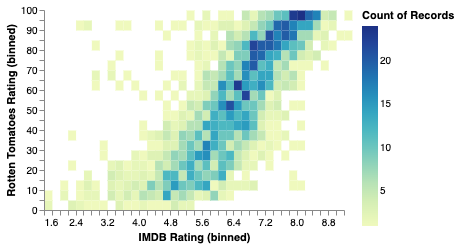

In [3]:
vega(full_spec)

The VegaFusion runtime provides a `pre_transform_extract` method that can be used to pre-apply data transformations and return that transformed datasets as pyarrow Tables.

In [4]:
vf.runtime.pre_transform_extract?

Signature:
vf.runtime.pre_transform_extract(
    spec,
    local_tz,
    default_input_tz=None,
    preserve_interactivity=True,
    inline_datasets=None,
)
Docstring:
Evaluate supported transforms in an input Vega specification and produce a new
specification with small pre-transformed datasets (under 100 rows) included inline
and larger inline datasets (100 rows or more) are extracted into pyarrow tables.

:param spec: A Vega specification dict or JSON string
:param local_tz: Name of timezone to be considered local. E.g. 'America/New_York'.
    This can be computed for the local system using the tzlocal package and the
    tzlocal.get_localzone_name() function.
:param default_input_tz: Name of timezone (e.g. 'America/New_York') that naive datetime
    strings should be interpreted in. Defaults to `local_tz`.
:param preserve_interactivity: If True (default) then the interactive behavior of
    the chart will pre preserved. This requires that all the data that participates
    in inter

In [5]:
transformed_spec, datasets, warnings = vf.runtime.pre_transform_extract(full_spec, local_tz)

In [6]:
print(json.dumps(transformed_spec, indent=2))

{
  "$schema": "https://vega.github.io/schema/vega/v5.json",
  "data": [
    {
      "name": "source_0"
    },
    {
      "name": "source_0_color_domain___count",
      "values": [
        {
          "min": 1,
          "max": 24
        }
      ]
    }
  ],
  "signals": [
    {
      "name": "bin_maxbins_40_Rotten_Tomatoes_Rating_bins",
      "value": {
        "fields": [
          "Rotten Tomatoes Rating"
        ],
        "fname": "bin_Rotten Tomatoes Rating",
        "start": 0.0,
        "step": 5.0,
        "stop": 100.0
      }
    },
    {
      "name": "bin_maxbins_60_IMDB_Rating_bins",
      "value": {
        "fields": [
          "IMDB Rating"
        ],
        "fname": "bin_IMDB Rating",
        "start": 1.6,
        "step": 0.2,
        "stop": 9.200000000000001
      }
    }
  ],
  "marks": [
    {
      "type": "rect",
      "name": "marks",
      "from": {
        "data": "source_0"
      },
      "encode": {
        "update": {
          "y2": {
            "fiel

In [7]:
print(warnings)

[]


In [8]:
len(datasets)

1

In [9]:
(name, scope, table) = datasets[0]

In [10]:
print(name)
print(scope)

source_0
[]


In [11]:
table

pyarrow.Table
__count: int64
bin_maxbins_40_Rotten Tomatoes Rating: double
bin_maxbins_40_Rotten Tomatoes Rating_end: double
bin_maxbins_60_IMDB Rating: double
bin_maxbins_60_IMDB Rating_end: double
----
__count: [[1,7,8,20,18,...,1,1,1,1,1]]
bin_maxbins_40_Rotten Tomatoes Rating: [[60,25,85,80,80,...,15,70,90,20,10]]
bin_maxbins_40_Rotten Tomatoes Rating_end: [[65,30,90,85,85,...,20,75,95,25,15]]
bin_maxbins_60_IMDB Rating: [[3.4000000000000004,5.800000000000001,7,7,7.4,...,6.6,8.200000000000001,4.4,4.2,7.800000000000001]]
bin_maxbins_60_IMDB Rating_end: [[3.6000000000000005,6.000000000000001,7.2,7.2,7.6000000000000005,...,6.8,8.4,4.6000000000000005,4.4,8]]

---

In the transformed spec above, you can see that the `source_0` dataset has a name but no values or URL. The first entry of the returned `datasets` list is a three-element tuple of `(name, scope, table)`, where `name` is `source_0`, scope is `[]` (indicating that the dataset is at the top-level in the spec, not nested under a group mark), and `table` is a pyarrow table that the client should insert back into the spec before rendering.

## Example 2: DataFrame dataset
Suppose the `movies.json` dataset is already loaded into memory as a pandas `DataFrame`

In [12]:
movies = pd.read_json("https://raw.githubusercontent.com/vega/vega-datasets/master/data/movies.json")
movies.head()

,Title,US Gross,Worldwide Gross,US DVD Sales,Production Budget,Release Date,MPAA Rating,Running Time min,Distributor,Source,Major Genre,Creative Type,Director,Rotten Tomatoes Rating,IMDB Rating,IMDB Votes
0,The Land Girls,146083.0,146083.0,NaN,8000000.0,Jun 12 1998,R,NaN,Gramercy,None,None,None,None,NaN,6.1,1071.0
1,"First Love, Last Rites",10876.0,10876.0,NaN,300000.0,Aug 07 1998,R,NaN,Strand,None,Drama,None,None,NaN,6.9,207.0
2,I Married a Strange Person,203134.0,203134.0,NaN,250000.0,Aug 28 1998,None,NaN,Lionsgate,None,Comedy,None,None,NaN,6.8,865.0
3,Let's Talk About Sex,373615.0,373615.0,NaN,300000.0,Sep 11 1998,None,NaN,Fine Line,None,Comedy,None,None,13.0,NaN,NaN
4,Slam,1009819.0,1087521.0,NaN,1000000.0,Oct 09 1998,R,NaN,Trimark,Original Screenplay,Drama,Contemporary Fiction,None,62.0,3.4,165.0


---

This DataFrame can be provided to `pre_transform_extract` method as a "named dataset", with name `"movies"`.  When a `DataFrame` is provided as a named dataset, it can be referenced by name from within the Vega specification using a special url syntax. In this case, the moveis dataset can be referenced as `"vegafusion+dataset://movies"`.  Here is the full specification:

In [13]:
full_spec_named = json.loads(r"""
{
  "$schema": "https://vega.github.io/schema/vega/v5.json",
  "background": "white",
  "padding": 5,
  "width": 300,
  "height": 200,
  "style": "cell",
  "data": [
    {
      "name": "source_0",
      "url": "vegafusion+dataset://movies",
      "format": {"type": "json"},
      "transform": [
        {
          "type": "filter",
          "expr": "(isValid(datum[\"IMDB Rating\"]) && isFinite(+datum[\"IMDB Rating\"])) && (isValid(datum[\"Rotten Tomatoes Rating\"]) && isFinite(+datum[\"Rotten Tomatoes Rating\"]))"
        },
        {
          "type": "extent",
          "field": "IMDB Rating",
          "signal": "bin_maxbins_60_IMDB_Rating_extent"
        },
        {
          "type": "bin",
          "field": "IMDB Rating",
          "as": [
            "bin_maxbins_60_IMDB Rating",
            "bin_maxbins_60_IMDB Rating_end"
          ],
          "signal": "bin_maxbins_60_IMDB_Rating_bins",
          "extent": {"signal": "bin_maxbins_60_IMDB_Rating_extent"},
          "maxbins": 60
        },
        {
          "type": "extent",
          "field": "Rotten Tomatoes Rating",
          "signal": "bin_maxbins_40_Rotten_Tomatoes_Rating_extent"
        },
        {
          "type": "bin",
          "field": "Rotten Tomatoes Rating",
          "as": [
            "bin_maxbins_40_Rotten Tomatoes Rating",
            "bin_maxbins_40_Rotten Tomatoes Rating_end"
          ],
          "signal": "bin_maxbins_40_Rotten_Tomatoes_Rating_bins",
          "extent": {"signal": "bin_maxbins_40_Rotten_Tomatoes_Rating_extent"},
          "maxbins": 40
        },
        {
          "type": "aggregate",
          "groupby": [
            "bin_maxbins_60_IMDB Rating",
            "bin_maxbins_60_IMDB Rating_end",
            "bin_maxbins_40_Rotten Tomatoes Rating",
            "bin_maxbins_40_Rotten Tomatoes Rating_end"
          ],
          "ops": ["count"],
          "fields": [null],
          "as": ["__count"]
        },
        {
          "type": "filter",
          "expr": "isValid(datum[\"bin_maxbins_60_IMDB Rating\"]) && isFinite(+datum[\"bin_maxbins_60_IMDB Rating\"]) && isValid(datum[\"bin_maxbins_40_Rotten Tomatoes Rating\"]) && isFinite(+datum[\"bin_maxbins_40_Rotten Tomatoes Rating\"])"
        }
      ]
    }
  ],
  "marks": [
    {
      "name": "marks",
      "type": "rect",
      "style": ["rect"],
      "from": {"data": "source_0"},
      "encode": {
        "update": {
          "fill": {"scale": "color", "field": "__count"},
          "description": {
            "signal": "\"IMDB Rating (binned): \" + (!isValid(datum[\"bin_maxbins_60_IMDB Rating\"]) || !isFinite(+datum[\"bin_maxbins_60_IMDB Rating\"]) ? \"null\" : format(datum[\"bin_maxbins_60_IMDB Rating\"], \"\") + \" – \" + format(datum[\"bin_maxbins_60_IMDB Rating_end\"], \"\")) + \"; Rotten Tomatoes Rating (binned): \" + (!isValid(datum[\"bin_maxbins_40_Rotten Tomatoes Rating\"]) || !isFinite(+datum[\"bin_maxbins_40_Rotten Tomatoes Rating\"]) ? \"null\" : format(datum[\"bin_maxbins_40_Rotten Tomatoes Rating\"], \"\") + \" – \" + format(datum[\"bin_maxbins_40_Rotten Tomatoes Rating_end\"], \"\")) + \"; Count of Records: \" + (format(datum[\"__count\"], \"\"))"
          },
          "x2": {
            "scale": "x",
            "field": "bin_maxbins_60_IMDB Rating",
            "offset": 0.5
          },
          "x": {
            "scale": "x",
            "field": "bin_maxbins_60_IMDB Rating_end",
            "offset": 0.5
          },
          "y2": {
            "scale": "y",
            "field": "bin_maxbins_40_Rotten Tomatoes Rating",
            "offset": 0.5
          },
          "y": {
            "scale": "y",
            "field": "bin_maxbins_40_Rotten Tomatoes Rating_end",
            "offset": 0.5
          }
        }
      }
    }
  ],
  "scales": [
    {
      "name": "x",
      "type": "linear",
      "domain": {
        "signal": "[bin_maxbins_60_IMDB_Rating_bins.start, bin_maxbins_60_IMDB_Rating_bins.stop]"
      },
      "range": [0, {"signal": "width"}],
      "bins": {"signal": "bin_maxbins_60_IMDB_Rating_bins"},
      "zero": false
    },
    {
      "name": "y",
      "type": "linear",
      "domain": {
        "signal": "[bin_maxbins_40_Rotten_Tomatoes_Rating_bins.start, bin_maxbins_40_Rotten_Tomatoes_Rating_bins.stop]"
      },
      "range": [{"signal": "height"}, 0],
      "bins": {"signal": "bin_maxbins_40_Rotten_Tomatoes_Rating_bins"},
      "zero": false
    },
    {
      "name": "color",
      "type": "linear",
      "domain": {"data": "source_0", "field": "__count"},
      "range": "heatmap",
      "interpolate": "hcl",
      "zero": false
    }
  ],
  "axes": [
    {
      "scale": "x",
      "orient": "bottom",
      "grid": false,
      "title": "IMDB Rating (binned)",
      "labelFlush": true,
      "labelOverlap": true,
      "tickCount": {"signal": "ceil(width/10)"},
      "zindex": 1
    },
    {
      "scale": "y",
      "orient": "left",
      "grid": false,
      "title": "Rotten Tomatoes Rating (binned)",
      "labelOverlap": true,
      "tickCount": {"signal": "ceil(height/10)"},
      "zindex": 1
    }
  ],
  "legends": [
    {
      "fill": "color",
      "gradientLength": {"signal": "clamp(height, 64, 200)"},
      "title": "Count of Records"
    }
  ],
  "config": {"style": {"cell": {"stroke": "transparent"}}}
}
""")

In [14]:
transformed_spec, datasets, warnings = vf.runtime.pre_transform_extract(
    full_spec_named, local_tz, inline_datasets=dict(movies=movies)
)

In [15]:
print(warnings)

[]


In [16]:
print(json.dumps(transformed_spec, indent=2))

{
  "$schema": "https://vega.github.io/schema/vega/v5.json",
  "data": [
    {
      "name": "source_0"
    },
    {
      "name": "source_0_color_domain___count",
      "values": [
        {
          "min": 1,
          "max": 24
        }
      ]
    }
  ],
  "signals": [
    {
      "name": "bin_maxbins_60_IMDB_Rating_bins",
      "value": {
        "fields": [
          "IMDB Rating"
        ],
        "fname": "bin_IMDB Rating",
        "start": 1.6,
        "step": 0.2,
        "stop": 9.200000000000001
      }
    },
    {
      "name": "bin_maxbins_40_Rotten_Tomatoes_Rating_bins",
      "value": {
        "fields": [
          "Rotten Tomatoes Rating"
        ],
        "fname": "bin_Rotten Tomatoes Rating",
        "start": 0.0,
        "step": 5.0,
        "stop": 100.0
      }
    }
  ],
  "marks": [
    {
      "type": "rect",
      "name": "marks",
      "from": {
        "data": "source_0"
      },
      "encode": {
        "update": {
          "fill": {
            "fi

In [17]:
len(datasets)

1

In [18]:
(name, scope, table) = datasets[0]

In [19]:
print(name)
print(scope)

source_0
[]


In [20]:
table

pyarrow.Table
__count: int64
bin_maxbins_40_Rotten Tomatoes Rating: double
bin_maxbins_40_Rotten Tomatoes Rating_end: double
bin_maxbins_60_IMDB Rating: double
bin_maxbins_60_IMDB Rating_end: double
----
__count: [[1,7,8,20,18,...,1,1,1,1,1]]
bin_maxbins_40_Rotten Tomatoes Rating: [[60,25,85,80,80,...,15,70,90,20,10]]
bin_maxbins_40_Rotten Tomatoes Rating_end: [[65,30,90,85,85,...,20,75,95,25,15]]
bin_maxbins_60_IMDB Rating: [[3.4000000000000004,5.800000000000001,7,7,7.4,...,6.6,8.200000000000001,4.4,4.2,7.800000000000001]]
bin_maxbins_60_IMDB Rating_end: [[3.6000000000000005,6.000000000000001,7.2,7.2,7.6000000000000005,...,6.8,8.4,4.6000000000000005,4.4,8]]

---

In the transformed spec above, you can see that the `source_0` dataset has a name but no values or URL. The first entry of the returned `datasets` list is a three-element tuple of `(name, scope, table)`, where `name` is `source_0`, scope is `[]` (indicating that the dataset is at the top-level in the spec, not nested under a group mark), and `table` is a pyarrow table that the client should insert back into the spec before rendering.